In [1]:
from keras.datasets import mnist

In [19]:
import numpy as np

In [2]:
data = mnist.load_data()

In [22]:
(xtrain,ytrain),(xtest,ytest) = data

In [4]:
import matplotlib.pyplot as plt

In [23]:
xtrain.shape

(60000, 28, 28)

In [24]:
out_size = xtrain.shape[1]*xtrain.shape[-1]

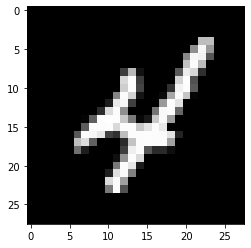

In [10]:
plt.imshow(xtrain[9,:,:],cmap='gray')
plt.show()

In [25]:
xtrain = ((xtrain.astype(float)-127.5)/127.5).reshape(60000,out_size)

In [26]:
xtrain.shape

(60000, 784)

In [17]:
xtrain[0,:]

array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.  

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, LeakyReLU
from keras.initializers import RandomNormal

In [12]:
from keras.optimizers import Adam

In [18]:
adam = Adam(learning_rate=0.0002, beta_1=0.5)

In [20]:
np.random.seed(101)
random_dim = 100

In [27]:
# Generator Model
gen = Sequential()
gen.add(Dense(256, input_dim=random_dim, kernel_initializer = RandomNormal(stddev=0.02)))
gen.add(LeakyReLU(0.2))
gen.add(Dense(512))
gen.add(LeakyReLU(0.2))
gen.add(Dense(1024))
gen.add(LeakyReLU(0.2))
gen.add(Dense(out_size, activation = 'tanh'))
gen.compile(optimizer = adam, loss='binary_crossentropy')

In [28]:
gen.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 784)              

In [29]:
# Discriminator Model
desc = Sequential()
desc.add(Dense(1024, input_dim=out_size, kernel_initializer = RandomNormal(stddev=0.02)))
desc.add(LeakyReLU(0.2))
desc.add(Dropout(0.3))
desc.add(Dense(512))
desc.add(LeakyReLU(0.2))
desc.add(Dropout(0.3))
desc.add(Dense(256))
desc.add(LeakyReLU(0.2))
desc.add(Dropout(0.3))
desc.add(Dense(1, activation = 'sigmoid'))
desc.compile(optimizer = adam, loss='binary_crossentropy')

In [30]:
desc.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)              

In [31]:
desc.trainable = False

In [32]:
model_input = Input(shape = (random_dim,))
model_output = desc(gen(model_input))
gan = Model(inputs=model_input, outputs=model_output)

In [34]:
gan.compile(optimizer=adam, loss='binary_crossentropy')

In [35]:
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [48]:
import datetime as dt

In [56]:
def train(epochs=1, batch_size=128):
    batch_count = xtrain.shape[0] // batch_size
    for epoch in range(1,epochs+1):
        print('Epoch {}/{} is going on............'.format(epoch,epochs))
        print(dt.datetime.now())
        for batch in range(batch_count):            
            print('#',end='')
            noise = np.random.normal(0,1,size=[batch_size,random_dim])
            gen_img = gen.predict(noise)
            
            # for discriminator
            batch_data = xtrain[np.random.randint(0,xtrain.shape[0], size=batch_size)]
            x_combined = np.concatenate([batch_data,gen_img])
            y_combined = np.zeros(2*batch_size)
            y_combined[:batch_size] = 1 # 0.95
            
            desc.trainable = True
            desc.train_on_batch(x_combined,y_combined)
            desc.trainable = False
            
            # for generator
            x_gen = np.random.normal(0,1,size=[batch_size,random_dim])
            y_gen = np.ones(batch_size)
            gan.train_on_batch(x_gen,y_gen)
        print('')
        show_results(epoch,gen)        
        print(dt.datetime.now())
        print('-'*30)

In [57]:
def show_results(epoch, generator):
    noise = np.random.normal(0,1,size=[batch_size,random_dim])
    gen_img = generator.predict(noise)    
    gen_img = gen_img.reshape(batch_size,28,28)
    plt.figure(figsize=(12,10))
    for i in range(gen_img.shape[0]):
        plt.subplot(13,10,i+1)
        plt.imshow(gen_img[i], cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()

Epoch 1/1 is going on............
2021-08-07 18:45:41.758124
####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
2021-08-07 18:47:33.819390
------------------------------


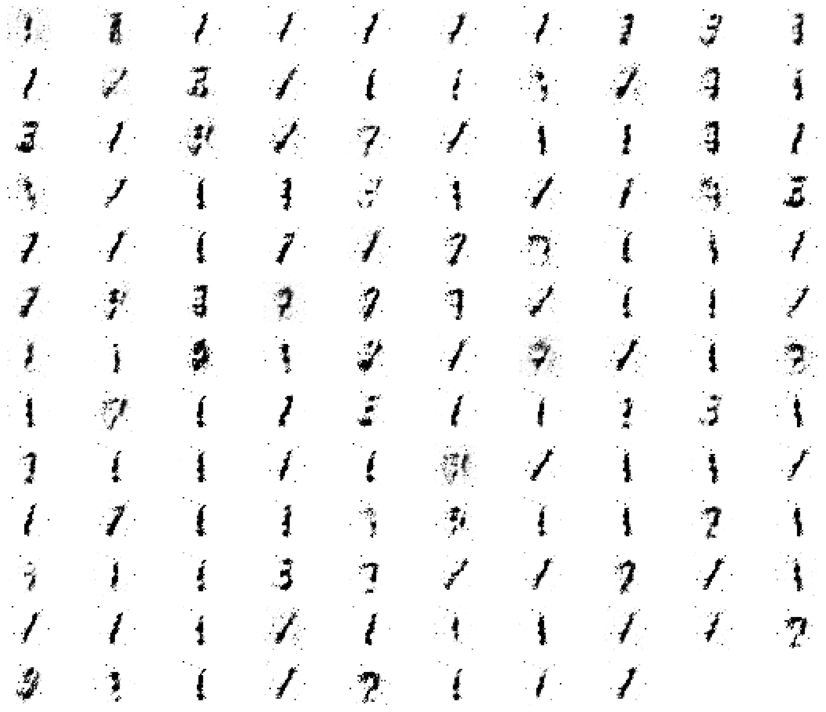

In [58]:
train()

In [59]:
gen.save('myGen.h5')